# Dependencies

In [2]:
from allensdk.core.cell_types_cache import CellTypesCache
import pandas as pd
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor
import numpy as np
import matplotlib.pyplot as plt
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS

# Cell Types dataset

In [3]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# this saves the NWB file to 'cell_types/specimen_464212183/ephys.nwb'
cell_specimen_id = 464212183
data_set = ctc.get_ephys_data(cell_specimen_id)

/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stimulus = stimulus_dataset.value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:109: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  response = swp['response']['timeseries']['data'].value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:125: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_idx_start = swp['stimulus']['idx_start'].value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:126: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_length = swp['stimulus']['count'].value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:135: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  exp_idx_start = 

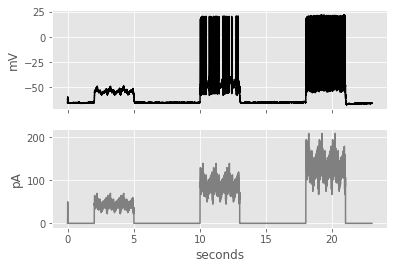

In [5]:
# for n in sweep_numbers:
sweep_number = 37
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()

In [30]:
# download all cells
cells = ctc.get_cells()
print("Total cells: %d" % len(cells))

# mouse cells
cells = ctc.get_cells(species=[CellTypesApi.MOUSE])
print("Mouse cells: %d" % len(cells))

# cells with reconstructions
cells = ctc.get_cells(require_reconstruction = True)
print("Cells with reconstructions: %d" % len(cells))

# all cre positive cells
cells = ctc.get_cells(reporter_status = RS.POSITIVE)
print("Cre-positive cells: %d" % len(cells))

# cre negative cells with reconstructions
cells = ctc.get_cells(require_reconstruction = True, 
                      reporter_status = RS.NEGATIVE)
print("Cre-negative cells with reconstructions: %d" % len(cells))

Total cells: 2333
Mouse cells: 1920
Cells with reconstructions: 667
Cre-positive cells: 1815
Cre-negative cells with reconstructions: 38


# Electrophysiological features (precomputed)

In [49]:
ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)

print("Ephys. features available for %d cells" % len(ef_df))

cell_ephys_features = ef_df.loc[23]
cell_ephys_features

Ephys. features available for 2333 cells


adaptation                                      NaN
avg_isi                                         NaN
electrode_0_pa                              61.9175
f_i_curve_slope                           0.0349141
fast_trough_t_long_square                   1.16456
fast_trough_t_ramp                          8.73023
fast_trough_t_short_square                  1.02509
fast_trough_v_long_square                  -53.4375
fast_trough_v_ramp                         -54.7396
fast_trough_v_short_square                 -55.0625
has_burst                                     False
has_delay                                     False
has_pause                                     False
id                                        530259209
input_resistance_mohm                       74.9215
latency                                     0.08012
peak_t_long_square                          1.16248
peak_t_ramp                                  8.7279
peak_t_short_square                         1.02353
peak_v_long_

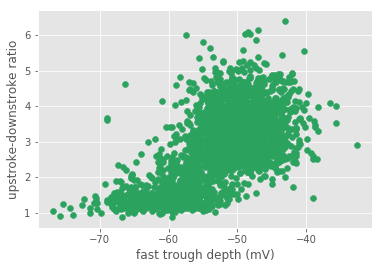

In [50]:
plt.figure()
plt.scatter(ef_df['fast_trough_v_long_square'], 
            ef_df['upstroke_downstroke_ratio_long_square'], color='#2ca25f')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")
plt.show()

First 5 rows of A:
[[-56.37500381   1.        ]
 [-54.           1.        ]
 [-59.5          1.        ]
 [-47.53125      1.        ]
 [-48.43750381   1.        ]]
m 0.1046880718760179 c 8.355078903861306


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


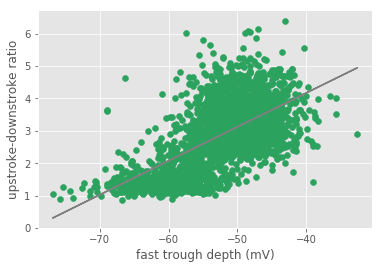

In [51]:
A = np.vstack([ef_df['fast_trough_v_long_square'], 
               np.ones_like(ef_df['upstroke_downstroke_ratio_long_square'])]).T

print("First 5 rows of A:")
print(A[:5, :])

m, c = np.linalg.lstsq(A, ef_df['upstroke_downstroke_ratio_long_square'])[0]
print("m", m, "c", c)

plt.figure()
plt.scatter(ef_df['fast_trough_v_long_square'], 
            ef_df['upstroke_downstroke_ratio_long_square'], 
            color='#2ca25f')
plt.plot(ef_df['fast_trough_v_long_square'],
         m * ef_df['fast_trough_v_long_square'] + c, c='gray')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")
plt.show()

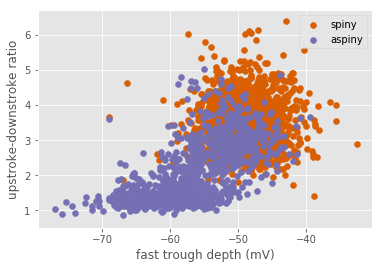

In [52]:
cells = ctc.get_cells()

# we want to add dendrite type as a column to the ephys. features dataframe
# first build an index on cell specimen ID, then create array of dendrite types
cell_index = { c['id']: c for c in cells }
dendrite_types = [ cell_index[cid]['dendrite_type'] for cid in ef_df['specimen_id'] ]

# now add the new column
ef_df['dendrite_type'] = pd.Series(dendrite_types, index=ef_df.index)
 
fig = plt.figure()

for d_type, color in [ ["spiny", "#d95f02"], ["aspiny", "#7570b3"] ]:
    df = ef_df[ef_df['dendrite_type'] == d_type]
    plt.scatter(df['fast_trough_v_long_square'], 
                df['upstroke_downstroke_ratio_long_square'], 
                color=color, label=d_type)

    plt.ylabel("upstroke-downstroke ratio")
    plt.xlabel("fast trough depth (mV)")
    plt.legend(loc='best')
    
plt.show()

# Electrophysiological features (computation)

In [35]:
sweep_number = 35
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
sweep_ext.process_spikes()

print("Avg spike threshold: %.01f mV" % sweep_ext.spike_feature("threshold_v").mean())
print("Avg spike width: %.02f ms" %  (1e3 * np.nanmean(sweep_ext.spike_feature("width"))))

/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stimulus = stimulus_dataset.value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:109: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  response = swp['response']['timeseries']['data'].value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:125: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_idx_start = swp['stimulus']['idx_start'].value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:126: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_length = swp['stimulus']['count'].value
/anaconda3/lib/python3.6/site-packages/allensdk/core/nwb_data_set.py:135: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  exp_idx_start = 

Avg spike threshold: -35.5 mV
Avg spike width: 0.94 ms


In [36]:
sweep_ext.spike_feature_keys()

['threshold_index',
 'clipped',
 'threshold_t',
 'threshold_v',
 'threshold_i',
 'peak_index',
 'peak_t',
 'peak_v',
 'peak_i',
 'trough_index',
 'trough_t',
 'trough_v',
 'trough_i',
 'upstroke_index',
 'upstroke',
 'upstroke_t',
 'upstroke_v',
 'downstroke_index',
 'downstroke',
 'downstroke_t',
 'downstroke_v',
 'isi_type',
 'fast_trough_index',
 'fast_trough_t',
 'fast_trough_v',
 'fast_trough_i',
 'adp_index',
 'adp_t',
 'adp_v',
 'adp_i',
 'slow_trough_index',
 'slow_trough_t',
 'slow_trough_v',
 'slow_trough_i',
 'width',
 'upstroke_downstroke_ratio']

In [37]:
spike_times = sweep_ext.spike_feature("threshold_t")

print(spike_times[:5])  # print just the first 5 spike times

[1.02811  1.040935 1.053675 1.068645 1.082835]


(0.9, 1.2)

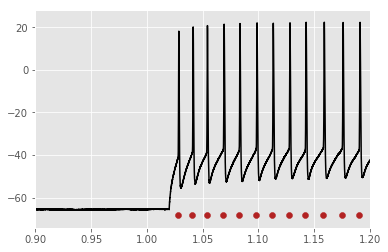

In [38]:
fig = plt.figure()
p = plt.plot(t, v, color='black')
min_v = v.min()
v_level = min_v - 5
plt.scatter(spike_times, np.ones(len(spike_times)) * min_v, c='firebrick')
plt.xlim(0.9, 1.2)

(1.015, 1.08)

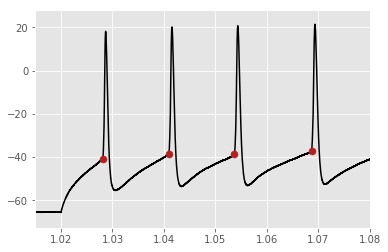

In [39]:
fig = plt.figure()
plt.plot(t, v, color='black')

threshold_v = sweep_ext.spike_feature("threshold_v")
plt.scatter(spike_times, threshold_v, s=50, c='firebrick', zorder=20)
plt.xlim(1.015, 1.08)